# Coadds, Subtractions, and Photometry with the ZUDS Pipeline

This notebook shows how to produce supernova light curves using the `zuds` pipeline, with only IPAC science images and masks as input. 

## Step 1. Installation and dependencies

To simplify getting set up, I recommend running this notebook within the `zuds` docker image. The docker image already has the key dependencies installed: the `zuds` python library, `sextractor >= 2.19.5`, `swarp >= 2.38.0`, and `hotpants >= 63e1260`. To check that all of these dependencies are working, execute the following cells and check that they return without errors:

In [1]:
import zuds

Configuration file "/home/zuds/.zuds" does not exist; initializing from defaults. Please edit the file and update it with your credentials.


In [2]:
!sex


         SExtractor  version 2.19.5 (2020-04-22)

Written by Emmanuel BERTIN <bertin@iap.fr>
Copyright 2012 IAP/CNRS/UPMC

visit http://astromatic.net/software/sextractor

SExtractor comes with ABSOLUTELY NO WARRANTY
You may redistribute copies of SExtractor
under the terms of the GNU General Public License.

> SYNTAX: sex <image> [<image2>][-c <configuration_file>][-<keyword> <value>]
> to dump a default configuration file:          sex -d 
> to dump a default extended configuration file: sex -dd 
> to dump a full list of measurement parameters: sex -dp 




In [3]:
!swarp


         SWarp  version 2.38.0 (2020-04-22)

Written by Emmanuel BERTIN <bertin@iap.fr>
Copyright 2010-2012 IAP/CNRS/UPMC

visit http://astromatic.net/software/swarp/

SWarp comes with ABSOLUTELY NO WARRANTY
You may redistribute copies of SWarp
under the terms of the GNU General Public License.

> SYNTAX: swarp image1 [image2 ...][@image_list1 [@image_list2 ...]]
		[-c <configuration_file>][-<keyword> <value>]
> to dump a default configuration file: SWarp -d 
> to dump a default extended configuration file: SWarp -dd 




In [4]:
!hotpants

Usage:  hotpants [options]
Version 5.1.11
Required options:
   [-inim fitsfile]  : comparison image to be differenced
   [-tmplim fitsfile]: template image
   [-outim fitsfile] : output difference image

Additional options:
   [-tu tuthresh]    : upper valid data count, template (25000)
   [-tuk tucthresh]  : upper valid data count for kernel, template (tuthresh)
   [-tl tlthresh]    : lower valid data count, template (0)
   [-tg tgain]       : gain in template (1)
   [-tr trdnoise]    : e- readnoise in template (0)
   [-tp tpedestal]   : ADU pedestal in template (0)
   [-tni fitsfile]   : input template noise array (undef)
   [-tmi fitsfile]   : input template mask image (undef)
   [-iu iuthresh]    : upper valid data count, image (25000)
   [-iuk iucthresh]  : upper valid data count for kernel, image (iuthresh)
   [-il ilthresh]    : lower valid data count, image (0)
   [-ig igain]       : gain in image (1)
   [-ir irdnoise]    : e- readnoise in image (0)
   [-ip ipedestal]   : ADU p

To roll your own `zuds` installation, you can install `sextractor`, `swarp`, and `hotpants` manually. Just make sure they are in your `PATH`. 

To install `zuds`, you can do `pip install zuds`. 

## Initializing the database

The `zuds` pipeline is backed by a `postgresql` database, which keeps precise track of your images, photometry, subtractions, references, etc. Interactions with the database are handled seamlessly for you using the SQLAlchemy object-relational mapper (ORM). You can run the database on your local machine, or connect to an instance running on a remote machine.  For the purposes of this demo, we recommend using `docker-compose up` to bring up both a `zuds` container (running this notebook) and a separate container for the `postgresql` database, on the same machine. 

The address of the database endpoint is controlled by the configuration file (by default `~/.zuds`). If you are running this demo within `docker-compose`, you don't need to modify `~/.zuds`. Otherwise, simply edit the file and update the `db_*` keywords to point to your database.

When you create a new database instance, you need to create the tables in the `zuds` schema. This only needs to be done once per database. To create all the tables, indices, foreign keys, etc., needed to process things, simply do:

In [5]:
zuds.create_tables()

Creating tables on database zuds
Refreshed tables:
 - acls
 - roles
 - role_acls
 - users
 - tokens
 - token_acls
 - user_roles
 - groups
 - group_users
 - streams
 - stream_groups
 - sources
 - group_sources
 - sourceviews
 - telescopes
 - group_telescopes
 - instruments
 - comments
 - photometry
 - spectra
 - thumbnails
 - usersocialauths
 - nonces
 - associations
 - codes
 - partials
 - ztffiles
 - alerts
 - ztffilecopies
 - httparchivecopies
 - tapecopies
 - tapearchives
 - jobs
 - forcephotjobs
 - alertjobs
 - failedsubtractions
 - pipelineregionfiles
 - pipelinefitscatalogs
 - forcedphotometry
 - calibratableimages
 - calibratedimages
 - scienceimages
 - coadds
 - referenceimages
 - sciencecoadds
 - realbogus
 - detections
 - dr8_north
 - dr8_south
 - clu_20190625
 - maskimages
 - singleepochsubtractions
 - multiepochsubtractions
 - job_images
 - stackedsubtraction_frames
 - coadd_images


## Step 3. Loading up some data

Now that the software is installed and the database is set up, we are ready to start processing some data. In this part of the demo we will read in five ZTF science images and masks. Real references should have more images, but for the sake of the demo we use a small number here.

At https://portal.nersc.gov/cfs/m937/demo.tar.gz, there is an example dataset of g-band ZTF images of a single field and chip, taken over a few months in 2019. On the docker image, this file has already been downloaded and extracted to `~/.data/`.

First we will read in the first ten images and masks to memory.

In [17]:
cd ~/.data

/home/zuds/.data


In [18]:
refimpaths = ['000717/c01/q2/zg/ztf_20190402288681_000717_zg_c01_o_q2_sciimg.fits',
              '000717/c01/q2/zg/ztf_20190401371632_000717_zg_c01_o_q2_sciimg.fits',
              '000717/c01/q2/zg/ztf_20190208501435_000717_zg_c01_o_q2_sciimg.fits',
              '000717/c01/q2/zg/ztf_20190305339653_000717_zg_c01_o_q2_sciimg.fits',
              '000717/c01/q2/zg/ztf_20190330390810_000717_zg_c01_o_q2_sciimg.fits']

refmskpaths = ['000717/c01/q2/zg/ztf_20190402288681_000717_zg_c01_o_q2_mskimg.fits',
               '000717/c01/q2/zg/ztf_20190401371632_000717_zg_c01_o_q2_mskimg.fits',
               '000717/c01/q2/zg/ztf_20190208501435_000717_zg_c01_o_q2_mskimg.fits',
               '000717/c01/q2/zg/ztf_20190305339653_000717_zg_c01_o_q2_mskimg.fits',
               '000717/c01/q2/zg/ztf_20190330390810_000717_zg_c01_o_q2_mskimg.fits']

In [19]:
scis = []
for ipath, mpath in zip(refimpaths, refmskpaths):
    
    # create a python object for each file
    sci = zuds.ScienceImage.from_file(ipath)
    msk = zuds.MaskImage.from_file(mpath)
    
    # associate each mask image with a science image
    msk.parent_image = sci
    
    # add the objects to the database session
    zuds.DBSession().add_all([sci, msk])
    scis.append(sci)

Mapping ztf_20190402288681_000717_zg_c01_o_q2_sciimg.fits to /home/zuds/.data/000717/c01/q2/zg/ztf_20190402288681_000717_zg_c01_o_q2_sciimg.fits
Mapping ztf_20190402288681_000717_zg_c01_o_q2_mskimg.fits to /home/zuds/.data/000717/c01/q2/zg/ztf_20190402288681_000717_zg_c01_o_q2_mskimg.fits
Mapping ztf_20190401371632_000717_zg_c01_o_q2_sciimg.fits to /home/zuds/.data/000717/c01/q2/zg/ztf_20190401371632_000717_zg_c01_o_q2_sciimg.fits
Mapping ztf_20190401371632_000717_zg_c01_o_q2_mskimg.fits to /home/zuds/.data/000717/c01/q2/zg/ztf_20190401371632_000717_zg_c01_o_q2_mskimg.fits
Mapping ztf_20190208501435_000717_zg_c01_o_q2_sciimg.fits to /home/zuds/.data/000717/c01/q2/zg/ztf_20190208501435_000717_zg_c01_o_q2_sciimg.fits
Mapping ztf_20190208501435_000717_zg_c01_o_q2_mskimg.fits to /home/zuds/.data/000717/c01/q2/zg/ztf_20190208501435_000717_zg_c01_o_q2_mskimg.fits
Mapping ztf_20190305339653_000717_zg_c01_o_q2_sciimg.fits to /home/zuds/.data/000717/c01/q2/zg/ztf_20190305339653_000717_zg_c01_o_

In [20]:
# We now have a ScienceImage for each image going into the reference.
scis[0]

<ScienceImage(id=1, created_at=2020-04-22 18:45:29.278028, basename=ztf_20190402288681_000717_zg_c01_o_q2_sciimg.fits, modified=2020-04-22 18:45:15.659301, type=sci, field=717, qid=2, fid=1, ccdid=1, ra=203.8518238973648, dec=38.06714254612549, ra1=204.42313975144478, dec1=38.48251119268394, ra2=204.37669462117884, dec2=37.617337340987504, ra3=203.28675819387328, dec3=37.64864281228764, ra4=203.32036972917308, dec4=38.51405009041646, header={'SIMPLE': True, 'BITPIX': -32, 'NAXIS': 2, 'NAXIS1': 3072, 'NAXIS2': 3080, 'BUNIT': 'Data Value', 'ORIGIN': 'Zwicky Transient Facility', 'OBSERVER': 'ZTF Robotic Observing Software', 'ROBOSOFT': '0.98.8  February 11, 2019', 'FITSSOFT': '0.98.8  February 11, 2019', 'INSTRUME': 'ZTF/MOSAIC', 'DETECTOR': '', 'DETSOFT': '', 'DETFIRM': '', 'IMGTYPE': 'object', 'EXPOSURE': 30.0, 'EXPTIME': 30.0, 'MODE_NUM': 0, 'CCDSUM': '1 1', 'PIXSCALE': 1.012, 'FILENAME': 'ztf_20190402288681_000717_zg_c01_o.fits', 'ORIGNAME': 'ztf_20190402288681_000717_zg_c01_o.fits', 

Populating the interactive namespace from numpy and matplotlib


/opt/conda/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['sci']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


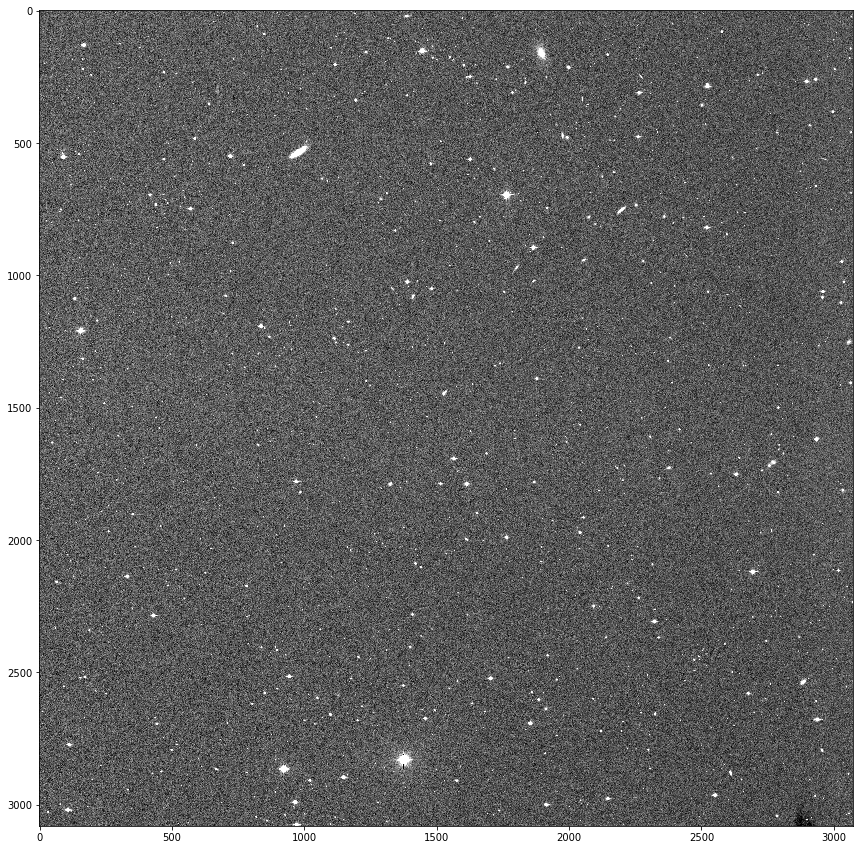

In [21]:
# We can show each image
%pylab inline
scis[0].show(figsize=(15, 15))

Populating the interactive namespace from numpy and matplotlib


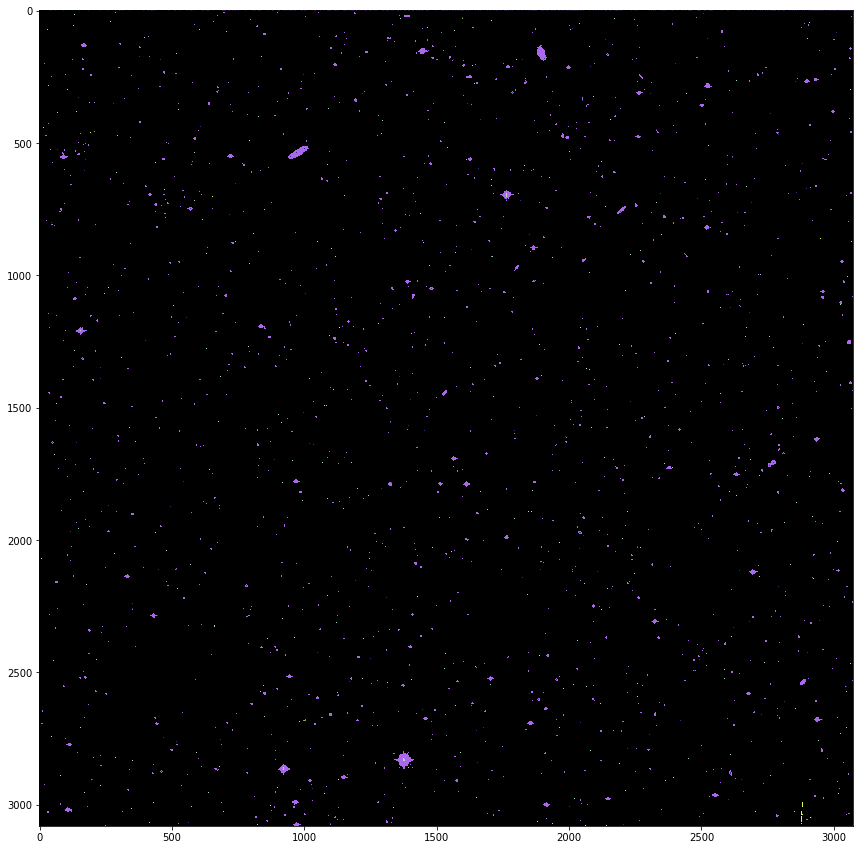

In [22]:
# And each mask
%pylab inline
scis[0].mask_image.show(figsize=(15, 15))

## Step 4. Create a reference image  
  
In this step, we combine the 10 science images above into a reference image. The weighting and background estimation is handled for you by `zuds`. 

In [23]:
ref = zuds.ReferenceImage.from_images(scis, 'ref.fits')

Mapping ztf_20190402288681_000717_zg_c01_o_q2_sciimg.fits to /home/zuds/.data/000717/c01/q2/zg/ztf_20190402288681_000717_zg_c01_o_q2_sciimg.fits
Mapping ztf_20190402288681_000717_zg_c01_o_q2_sciimg.fits to /home/zuds/.data/000717/c01/q2/zg/ztf_20190402288681_000717_zg_c01_o_q2_sciimg.fits
Mapping ztf_20190401371632_000717_zg_c01_o_q2_sciimg.fits to /home/zuds/.data/000717/c01/q2/zg/ztf_20190401371632_000717_zg_c01_o_q2_sciimg.fits
Mapping ztf_20190401371632_000717_zg_c01_o_q2_sciimg.fits to /home/zuds/.data/000717/c01/q2/zg/ztf_20190401371632_000717_zg_c01_o_q2_sciimg.fits
Mapping ztf_20190208501435_000717_zg_c01_o_q2_sciimg.fits to /home/zuds/.data/000717/c01/q2/zg/ztf_20190208501435_000717_zg_c01_o_q2_sciimg.fits
Mapping ztf_20190208501435_000717_zg_c01_o_q2_sciimg.fits to /home/zuds/.data/000717/c01/q2/zg/ztf_20190208501435_000717_zg_c01_o_q2_sciimg.fits
Mapping ztf_20190305339653_000717_zg_c01_o_q2_sciimg.fits to /home/zuds/.data/000717/c01/q2/zg/ztf_20190305339653_000717_zg_c01_o_

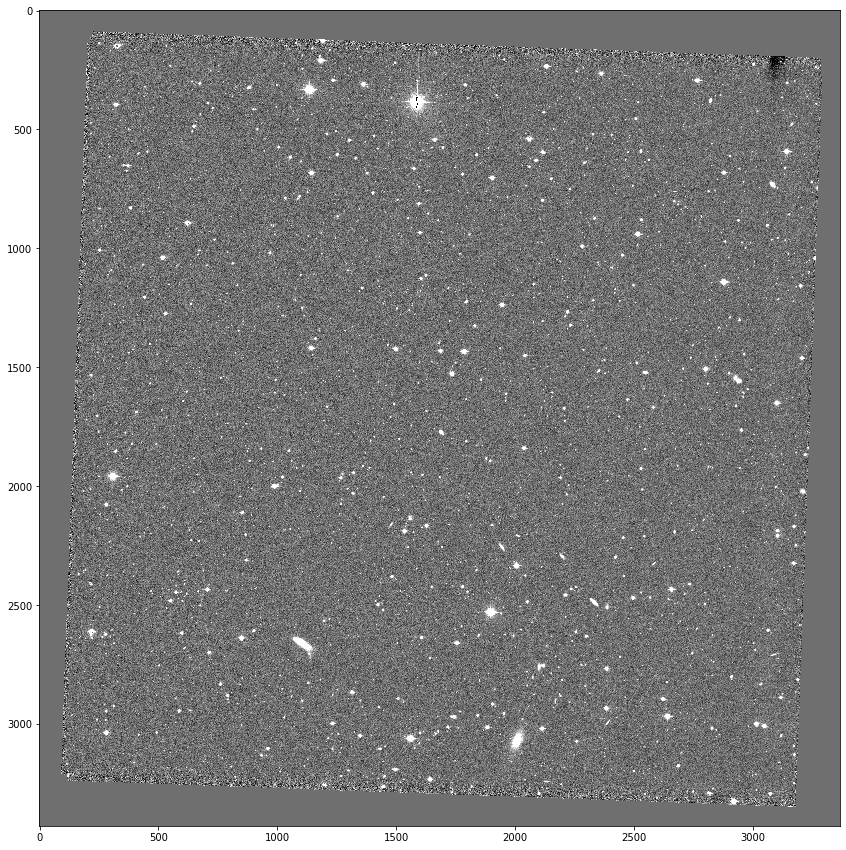

In [24]:
ref.show(figsize=(15,15))

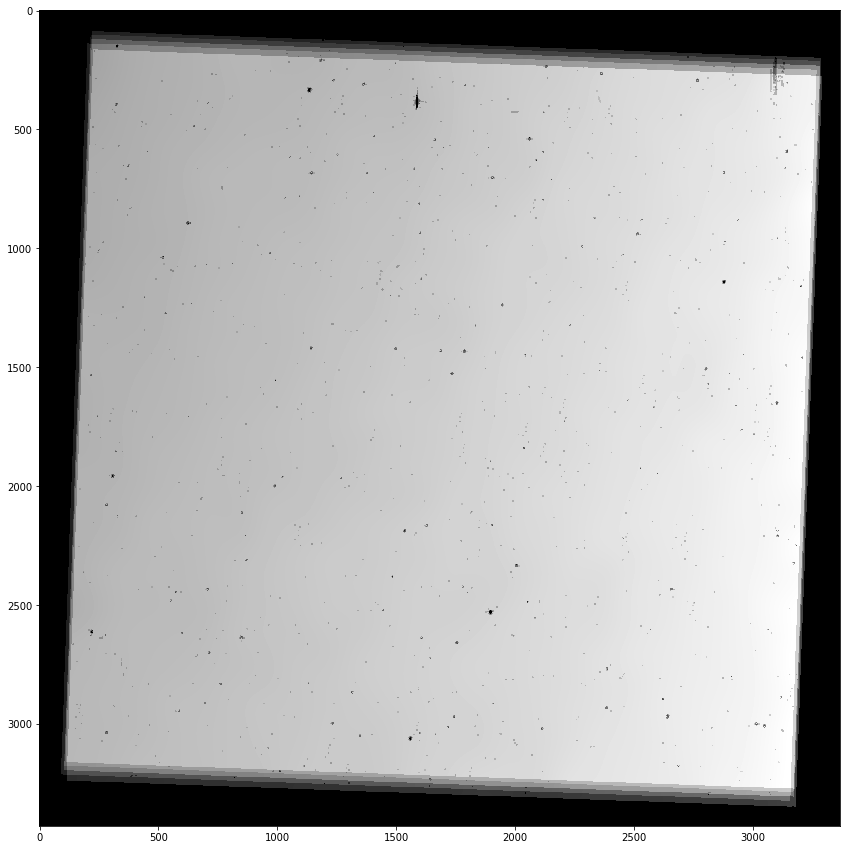

In [25]:
ref.weight_image.show(figsize=(15, 15))

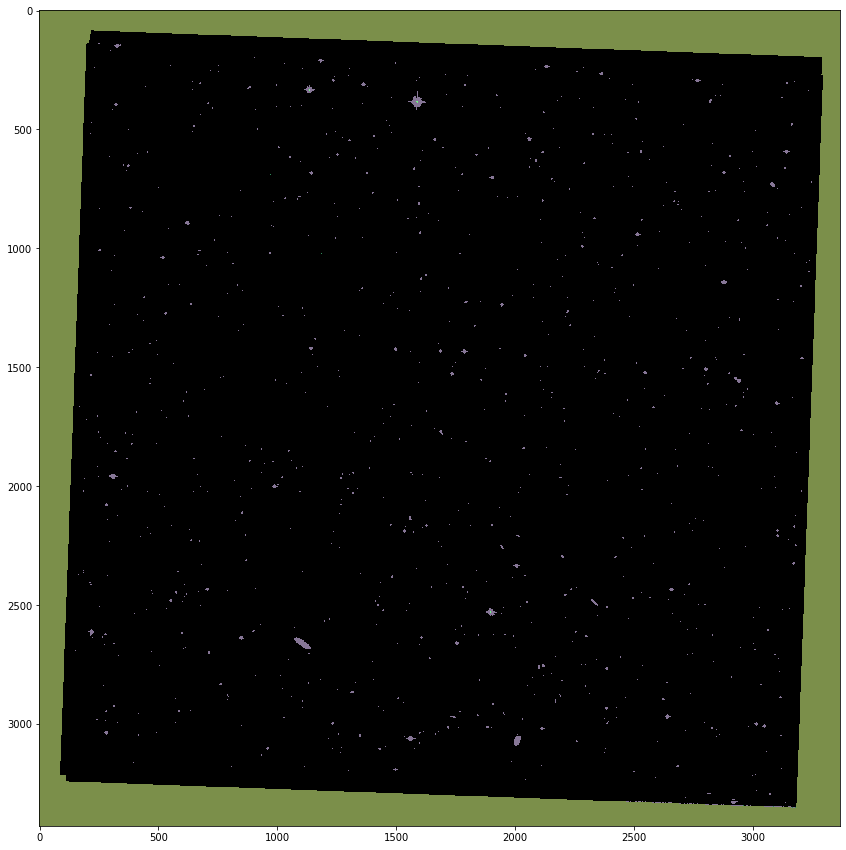

In [26]:
ref.mask_image.show(figsize=(15, 15))

In [27]:
print(ref)

{
  "id": null,
  "created_at": null,
  "basename": "ref.fits",
  "modified": null,
  "type": "ref",
  "field": 717,
  "qid": 2,
  "fid": 1,
  "ccdid": 1,
  "ra": 203.85795896968136,
  "dec": 38.076323517157,
  "ra1": 204.45497115502016,
  "dec1": 37.592752277760994,
  "ra2": 204.4628981710893,
  "dec2": 38.55711407322362,
  "ra3": 203.25266247311072,
  "dec3": 38.55711407322362,
  "ra4": 203.26058948917986,
  "dec4": 37.592752277760994,
  "header": {
    "SIMPLE": true,
    "BITPIX": -32,
    "NAXIS": 2,
    "NAXIS1": 3366,
    "NAXIS2": 3430,
    "EXTEND": true,
    "EQUINOX": 2000.0,
    "RADESYS": "ICRS",
    "CTYPE1": "RA---TAN",
    "CUNIT1": "deg",
    "CRVAL1": 203.8577803221,
    "CRPIX1": 1683.5,
    "CD1_1": -0.0002812591555994,
    "CD1_2": 0.0,
    "CTYPE2": "DEC--TAN",
    "CUNIT2": "deg",
    "CRVAL2": 38.07646414687,
    "CRPIX2": 1715.5,
    "CD2_1": 0.0,
    "CD2_2": 0.0002812591555994,
    "EXPTIME": 150.0,
    "GAIN": 87.34037156699,
    "SATURATE": 15838.0909621,
 

In [28]:
ref.input_images

[<ScienceImage(id=1, created_at=2020-04-22 18:45:29.278028, basename=ztf_20190402288681_000717_zg_c01_o_q2_sciimg.fits, modified=2020-04-22 18:45:15.659301, type=sci, field=717, qid=2, fid=1, ccdid=1, ra=203.8518238973648, dec=38.06714254612549, ra1=204.42313975144478, dec1=38.48251119268394, ra2=204.37669462117884, dec2=37.617337340987504, ra3=203.28675819387328, dec3=37.64864281228764, ra4=203.32036972917308, dec4=38.51405009041646, header={'SIMPLE': True, 'BITPIX': -32, 'NAXIS': 2, 'NAXIS1': 3072, 'NAXIS2': 3080, 'BUNIT': 'Data Value', 'ORIGIN': 'Zwicky Transient Facility', 'OBSERVER': 'ZTF Robotic Observing Software', 'ROBOSOFT': '0.98.8  February 11, 2019', 'FITSSOFT': '0.98.8  February 11, 2019', 'INSTRUME': 'ZTF/MOSAIC', 'DETECTOR': '', 'DETSOFT': '', 'DETFIRM': '', 'IMGTYPE': 'object', 'EXPOSURE': 30.0, 'EXPTIME': 30.0, 'MODE_NUM': 0, 'CCDSUM': '1 1', 'PIXSCALE': 1.012, 'FILENAME': 'ztf_20190402288681_000717_zg_c01_o.fits', 'ORIGNAME': 'ztf_20190402288681_000717_zg_c01_o.fits',

## Step 5. Load in the science images and masks for the subtractions
  
In this step, we load in a science image  that will go into the light curve. For the demo we are only doing one image - it gets the point across. In reality you can run this pipeline massively parallel across thousands or even millions of images. This image is later in time than the ones used to make the reference image

In [29]:
sciimgs = [
           "000717/c01/q2/zg/ztf_20190619280949_000717_zg_c01_o_q2_sciimg.fits"
]

mskimgs = [i.replace('sci', 'msk') for i in sciimgs]

In [30]:
scis = []
for ipath, mpath in zip(sciimgs, mskimgs):
    
    # create a python object for each file
    sci = zuds.ScienceImage.from_file(ipath)
    msk = zuds.MaskImage.from_file(mpath)
    
    # associate each mask image with a science image
    msk.parent_image = sci
    
    # add the objects to the database session
    zuds.DBSession().add_all([sci, msk])
    scis.append(sci)

Mapping ztf_20190619280949_000717_zg_c01_o_q2_sciimg.fits to /home/zuds/.data/000717/c01/q2/zg/ztf_20190619280949_000717_zg_c01_o_q2_sciimg.fits
Mapping ztf_20190619280949_000717_zg_c01_o_q2_mskimg.fits to /home/zuds/.data/000717/c01/q2/zg/ztf_20190619280949_000717_zg_c01_o_q2_mskimg.fits


## Step 6. Run the subtractions
  
In this step, we make the weight maps for each science image and then run the subtractions

In [31]:
for s in scis:
    # this step runs sextractor to calculate the weight map
    s.weight_image 

Mapping ztf_20190619280949_000717_zg_c01_o_q2_sciimg.cat to /home/zuds/.data/000717/c01/q2/zg/ztf_20190619280949_000717_zg_c01_o_q2_sciimg.cat
Mapping ztf_20190619280949_000717_zg_c01_o_q2_sciimg.rms.fits to /home/zuds/.data/000717/c01/q2/zg/ztf_20190619280949_000717_zg_c01_o_q2_sciimg.rms.fits
Mapping ztf_20190619280949_000717_zg_c01_o_q2_sciimg.weight.fits to /home/zuds/.data/000717/c01/q2/zg/ztf_20190619280949_000717_zg_c01_o_q2_sciimg.weight.fits


Now run the subs

In [32]:
subs = []
for s in scis:
    sub = zuds.SingleEpochSubtraction.from_images(s, ref)
    subs.append(sub)

Mapping ztf_20190619280949_000717_zg_c01_o_q2_sciimg.fits to /tmp/6452f23326f1470490dcfe122a7ed886/ztf_20190619280949_000717_zg_c01_o_q2_sciimg.fits
Reading ztf_20190619280949_000717_zg_c01_o_q2_sciimg.fits._rmsimg from /tmp/6452f23326f1470490dcfe122a7ed886/ztf_20190619280949_000717_zg_c01_o_q2_sciimg.rms.fits
Mapping ztf_20190619280949_000717_zg_c01_o_q2_sciimg.rms.fits to /tmp/6452f23326f1470490dcfe122a7ed886/ztf_20190619280949_000717_zg_c01_o_q2_sciimg.rms.fits
Mapping ztf_20190619280949_000717_zg_c01_o_q2_mskimg.fits to /tmp/6452f23326f1470490dcfe122a7ed886/ztf_20190619280949_000717_zg_c01_o_q2_mskimg.fits
Mapping ref.fits to /tmp/6452f23326f1470490dcfe122a7ed886/ref.fits
Reading ref.fits._weightimg from /tmp/6452f23326f1470490dcfe122a7ed886/ref.weight.fits
Mapping ref.weight.fits to /tmp/6452f23326f1470490dcfe122a7ed886/ref.weight.fits
Mapping ref.mask.fits to /tmp/6452f23326f1470490dcfe122a7ed886/ref.mask.fits
Mapping ref_aligned_to_ztf_20190619280949_000717_zg_c01_o_q2_sciimg.re

Mapping ref.mask_aligned_to_ztf_20190619280949_000717_zg_c01_o_q2_sciimg.remap.fits to /tmp/f196dd0f5541446dbf1822e2fb6b38cd/ref.mask_aligned_to_ztf_20190619280949_000717_zg_c01_o_q2_sciimg.remap.fits
Mapping ref.mask_aligned_to_ztf_20190619280949_000717_zg_c01_o_q2_sciimg.remap.weight.fits to /tmp/f196dd0f5541446dbf1822e2fb6b38cd/ref.mask_aligned_to_ztf_20190619280949_000717_zg_c01_o_q2_sciimg.remap.weight.fits
Mapping ref_aligned_to_ztf_20190619280949_000717_zg_c01_o_q2_sciimg.remap.fits to /tmp/6452f23326f1470490dcfe122a7ed886/ref_aligned_to_ztf_20190619280949_000717_zg_c01_o_q2_sciimg.remap.fits
Mapping ref.mask_aligned_to_ztf_20190619280949_000717_zg_c01_o_q2_sciimg.remap.fits to /tmp/6452f23326f1470490dcfe122a7ed886/ref_aligned_to_ztf_20190619280949_000717_zg_c01_o_q2_sciimg.remap.mask.fits


Mapping sub.ztf_20190619280949_000717_zg_c01_o_q2_sciimg_ref.mask.fits to /tmp/6452f23326f1470490dcfe122a7ed886/sub.ztf_20190619280949_000717_zg_c01_o_q2_sciimg_ref.mask.fits
Mapping sub.ztf_20190619280949_000717_zg_c01_o_q2_sciimg_ref.mask.bpm.fits to /tmp/6452f23326f1470490dcfe122a7ed886/sub.ztf_20190619280949_000717_zg_c01_o_q2_sciimg_ref.mask.bpm.fits
Mapping ztf_20190619280949_000717_zg_c01_o_q2_sciimg.weight.fits to /tmp/6452f23326f1470490dcfe122a7ed886/ztf_20190619280949_000717_zg_c01_o_q2_sciimg.weight.fits
Mapping ztf_20190619280949_000717_zg_c01_o_q2_sciimg.cat to /tmp/6452f23326f1470490dcfe122a7ed886/ztf_20190619280949_000717_zg_c01_o_q2_sciimg.cat
Mapping ztf_20190619280949_000717_zg_c01_o_q2_sciimg.bkgsub.fits to /tmp/6452f23326f1470490dcfe122a7ed886/ztf_20190619280949_000717_zg_c01_o_q2_sciimg.bkgsub.fits


/home/zuds/demo/zuds/image.py:175: RuntimeWarning: divide by zero encountered in true_divide
  rms[~ind] = 1 / np.sqrt(self.weight_image.data[~ind])


Mapping ref.rms.fits to /tmp/6452f23326f1470490dcfe122a7ed886/ref.rms.fits
Mapping ref.rms_aligned_to_ztf_20190619280949_000717_zg_c01_o_q2_sciimg.rms.remap.fits to /tmp/0eedaf7dc71e4e8f9eb297db78c293b8/ref.rms_aligned_to_ztf_20190619280949_000717_zg_c01_o_q2_sciimg.rms.remap.fits
Mapping ref.rms_aligned_to_ztf_20190619280949_000717_zg_c01_o_q2_sciimg.rms.remap.weight.fits to /tmp/0eedaf7dc71e4e8f9eb297db78c293b8/ref.rms_aligned_to_ztf_20190619280949_000717_zg_c01_o_q2_sciimg.rms.remap.weight.fits
Mapping ref.rms_aligned_to_ztf_20190619280949_000717_zg_c01_o_q2_sciimg.rms.remap.fits to /tmp/6452f23326f1470490dcfe122a7ed886/ref.rms_aligned_to_ztf_20190619280949_000717_zg_c01_o_q2_sciimg.rms.remap.fits


Mapping sub.ztf_20190619280949_000717_zg_c01_o_q2_sciimg_ref.fits to /home/zuds/.data/000717/c01/q2/zg/sub.ztf_20190619280949_000717_zg_c01_o_q2_sciimg_ref.fits
Mapping sub.ztf_20190619280949_000717_zg_c01_o_q2_sciimg_ref.mask.fits to /home/zuds/.data/000717/c01/q2/zg/sub.ztf_20190619280949_000717_zg_c01_o_q2_sciimg_ref.mask.fits
Mapping sub.ztf_20190619280949_000717_zg_c01_o_q2_sciimg_ref.rms.fits to /home/zuds/.data/000717/c01/q2/zg/sub.ztf_20190619280949_000717_zg_c01_o_q2_sciimg_ref.rms.fits


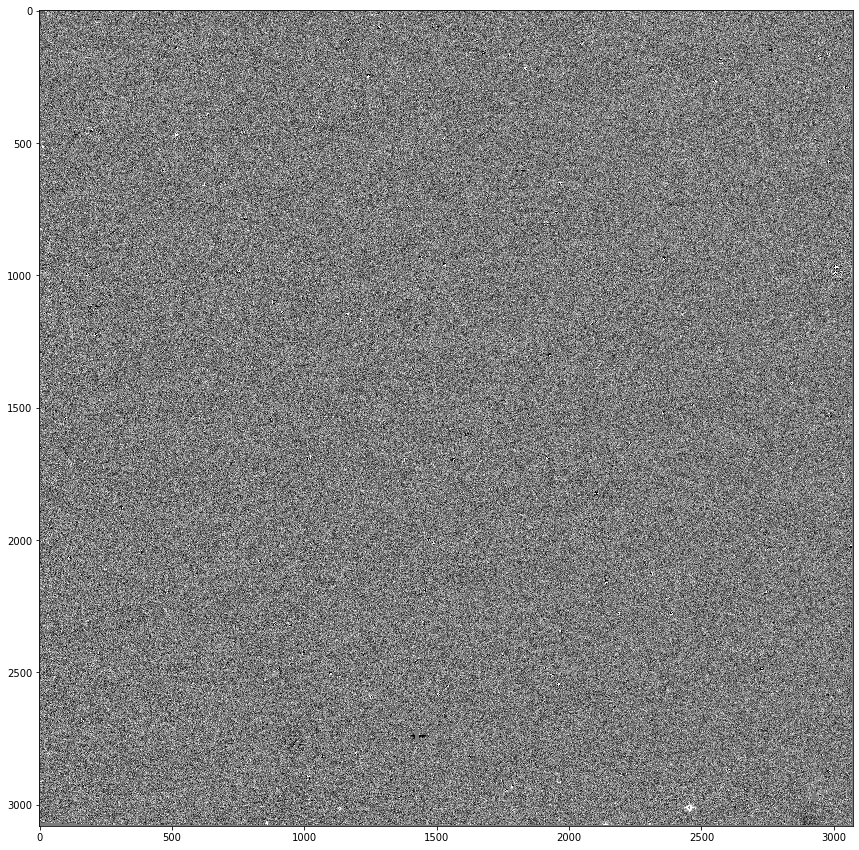

In [33]:
subs[-1].show(figsize=(15,15))

## Step 7. Create the supernova source and do the photometry

In [34]:
# Supernova ZUDS20dksuf - nearby SN Ia
source = zuds.Source(id='ZUDS20dksuf', ra=204.05419751958, dec=38.3550011412963)

In [35]:
phot = []
for sub in subs:
    p = sub.force_photometry(source, assume_background_subtracted=True)
    phot.extend(p)

In [36]:
phot

[<ForcedPhotometry(created_at=None, modified=None, id=None, flags=2050, ra=204.05419751958, dec=38.3550011412963, image_id=None, source_id=None, flux=12667.016228610204, fluxerr=61.217732238118565, zp=26.031384, filtercode=zg, obsjd=2458653.7809606)>]

In [37]:
zuds.DBSession().add_all(phot)

In [38]:
source.light_curve()

<Table length=1>
filter flags       flux       ...       mjd            zp    zpsys
 str4  int64     float64      ...     float64       float64   str2
------ ----- ---------------- ... ---------------- --------- -----
  ztfg  2050 12667.0162286102 ... 58653.2809605999 26.031384    ab

In [39]:
zuds.DBSession().commit()

## Step 8: The finished product

In [40]:
from IPython.display import Image
Image(filename='lc1.png') 

FileNotFoundError: [Errno 2] No such file or directory: 'lc1.png'

In [41]:
from IPython.display import Image
Image(filename='lc2.png') 

FileNotFoundError: [Errno 2] No such file or directory: 'lc2.png'